In [1]:
import pandas as pd
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import pdb
import scipy
from scipy.optimize import minimize, fmin
from scipy.stats import multivariate_normal
from tqdm.notebook import tqdm
import matplotlib
from mpl_toolkits import mplot3d
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['tahoma']

In [2]:
""" 
Obtaining data from a given expt
"""
csv_test = pd.read_csv('../auditory_categorization_noContext/important_things_not_included_in_assets/allTrials.csv')
csv_data = pd.read_csv('auditory_categorization_prolific_online_data/human_auditory_categorization_91686_2022-01-19_20h56.51_f8da6647-2fb7-444d-9e8c-e52b3a37d4b2/6139443561ab411be290efc1_categorization_task_2021-10-12_09h17.19.691.csv');
                       

In [3]:
n_tones = 3
n_trials = csv_data.shape[0]-47

"""
Get tones and values of keys pressed
"""
test_columns = list(csv_test.columns)
test_tones_name = test_columns.index('Name')
test_tones_col_idx = test_columns.index('Tones')
df_names = (csv_test.iloc[0:600,test_tones_name]).values
df_tones = (csv_test.iloc[0:600,test_tones_col_idx]).values

tones_array_orig = np.zeros((n_trials,n_tones))
tones_array_idxs_keep = []

for i_wav in range(603):
    if isinstance(csv_data['Name'][i_wav+46],str):
        tones_array_orig[i_wav,:] = np.array(df_tones[np.where(csv_data['Name'][i_wav+46]\
                                                          ==df_names)[0]][0][1:-1].split(',')).astype(float)  
        tones_array_idxs_keep += [i_wav]

        
df_tones = np.copy(tones_array_orig[tones_array_idxs_keep,:])
df_corrans = np.copy(csv_data['corrAns'][46:csv_data.shape[0]])[tones_array_idxs_keep]
df_keys = np.copy(csv_data['test_resp.keys'][46:csv_data.shape[0]])[tones_array_idxs_keep]

In [4]:
"""
Find no response cases in the expt
"""
no_response = np.intersect1d(np.where(df_keys!='h')[0],np.where(df_keys!='l')[0])
print("Did not respond to: ",no_response)

"""
Convert keys ['l','h'] to [0,1] and calculate accuracies
"""
corrans_num_orig = np.zeros_like(df_corrans)
corrans_num_orig[df_corrans == 'h'] = 1

keys_num_orig = np.zeros_like(df_keys)
keys_num_orig[df_keys == 'h'] = 1

corrans_num_150 = corrans_num_orig[:150]
keys_num_150 = keys_num_orig[:150]
tones_array_150 = df_tones[:150]
print("Got correct: ", np.sum(keys_num_150==corrans_num_150)/len(tones_array_150))
print("Got high correct: ", np.sum((keys_num_150)*(corrans_num_150))/np.sum(corrans_num_150))
print("Got low correct: ", np.sum((1-keys_num_150)*(1-corrans_num_150))/np.sum(1-corrans_num_150))

corrans_num_300 = corrans_num_orig[150:300]
keys_num_300 = keys_num_orig[150:300]
tones_array_300 = df_tones[150:300]
print("Got correct: ", np.sum(keys_num_300==corrans_num_300)/len(tones_array_300))
print("Got high correct: ", np.sum((keys_num_300)*(corrans_num_300))/np.sum(corrans_num_300))
print("Got low correct: ", np.sum((1-keys_num_300)*(1-corrans_num_300))/np.sum(1-corrans_num_300))

corrans_num_450 = corrans_num_orig[300:450]
keys_num_450 = keys_num_orig[300:450]
tones_array_450 = df_tones[300:450]
print("Got correct: ", np.sum(keys_num_450==corrans_num_450)/len(tones_array_450))
print("Got high correct: ", np.sum((keys_num_450)*(corrans_num_450))/np.sum(corrans_num_450))
print("Got low correct: ", np.sum((1-keys_num_450)*(1-corrans_num_450))/np.sum(1-corrans_num_450))

corrans_num_600 = corrans_num_orig[450:600]
keys_num_600 = keys_num_orig[450:600]
tones_array_600 = df_tones[450:600]
print("Got correct: ", np.sum(keys_num_600==corrans_num_600)/len(tones_array_600))
print("Got high correct: ", np.sum((keys_num_600)*(corrans_num_600))/np.sum(corrans_num_600))
print("Got low correct: ", np.sum((1-keys_num_600)*(1-corrans_num_600))/np.sum(1-corrans_num_600))

corrans_num = corrans_num_orig[:600]
keys_num = keys_num_orig[:600]
tones_array = df_tones[:600]
print("Got correct: ", np.sum(keys_num==corrans_num)/len(tones_array))
print("Got high correct: ", np.sum((keys_num)*(corrans_num))/np.sum(corrans_num))
print("Got low correct: ", np.sum((1-keys_num)*(1-corrans_num))/np.sum(1-corrans_num))

Did not respond to:  [ 46 219 390 485]
Got correct:  0.7266666666666667
Got high correct:  0.775
Got low correct:  0.6714285714285714
Got correct:  0.62
Got high correct:  0.6625
Got low correct:  0.5714285714285714
Got correct:  0.6533333333333333
Got high correct:  0.7714285714285715
Got low correct:  0.55
Got correct:  0.5866666666666667
Got high correct:  0.6619718309859155
Got low correct:  0.5189873417721519
Got correct:  0.6466666666666666
Got high correct:  0.717607973421927
Got low correct:  0.5752508361204013


In [5]:
trial_tones = np.repeat(tones_array,1,axis = 0)
trial_behaviour = np.reshape(keys_num,np.prod(keys_num.shape)) 
#this has been changed to check how values change with observer responses

expt_tones = np.arange(90,3000,1) #array of possible true tones
log_freq_seq_array = np.arange(0.6,4.7,0.1)
log_freq_percept = np.arange(0.6,4.7,0.1) # array of possible perceptual tones

idxs_with_response = np.delete(np.arange(len(trial_tones)),no_response)
trial_tones = trial_tones[idxs_with_response,:]
trial_behaviour = trial_behaviour[idxs_with_response]

log_freq_percept, log_freq_seq_array.shape

(array([0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8,
        1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. , 3.1,
        3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3, 4.4,
        4.5, 4.6]),
 (41,))

In [6]:
def gaussian(x, mean, sigma):
    return np.exp(-(x-mean)**2/(2*sigma**2))

def Tones3dgrid(latentTones, sigma):    
    
    input_array_0 = np.expand_dims(gaussian(log_freq_percept, latentTones[0], sigma), axis = 1)
    input_array_1 = np.expand_dims(gaussian(log_freq_percept, latentTones[1], sigma), axis = 1)
    input_array_2 = np.expand_dims(gaussian(log_freq_percept, latentTones[2], sigma), axis = 1)
    s0 = 1/np.sum(input_array_0); 
    s1 = 1/np.sum(input_array_1); 
    s2 = 1/np.sum(input_array_2);
    input_array_0 *= s0; 
    input_array_1 *= s1; 
    input_array_2 *= s2; 
    
    input_array_mat = np.expand_dims(input_array_0@input_array_1.T,axis=2)@(input_array_2.T) #p(T1,T2..|H)   
                                     
    return input_array_mat

def posterior_array(freq_input, n_tones, p_back, p_low, log_prior):
    """
    Arguments: 
    freq_input - range of all possible frequencies (percepts?)
    p_back - prob of background
    p_low - prob of low condition
    log_prior - list of prior parameters
    """
    
    log_prior_low_mean = log_prior[0]; log_prior_low_sigma = log_prior[2];
    log_prior_high_mean = log_prior[1]; log_prior_high_sigma = log_prior[2];
    prior_low = gaussian(x=freq_input, mean=log_prior_low_mean, sigma=log_prior_low_sigma)
    prior_high = gaussian(x=freq_input, mean=log_prior_high_mean, sigma=log_prior_high_sigma)
    prior_dist_mixed_high = p_back*(1/len(freq_input)) + (1-p_back)*prior_high \
    #mixture model with p(T|B) = 1/no. of possible freqs
    prior_dist_mixed_high /= prior_dist_mixed_high.sum() #normalizing
    prior_dist_mixed_high = np.expand_dims(prior_dist_mixed_high, axis = 1)
    prior_dist_mixed_low = p_back*(1/len(freq_input)) + (1-p_back)*prior_low \
    #mixture model with p(T|B) = 1/no. of possible freqs
    prior_dist_mixed_low /= prior_dist_mixed_low.sum() #normalizing
    prior_dist_mixed_low = np.expand_dims(prior_dist_mixed_low, axis = 1)
        
    if n_tones == 3:
        prior_tones_low = np.expand_dims(prior_dist_mixed_low@np.transpose\
                                         (prior_dist_mixed_low),axis=2)@np.transpose(prior_dist_mixed_low) \
        #p(T1,T2..|L) 
        
        prior_tones_high = np.expand_dims(prior_dist_mixed_high@np.transpose\
                                          (prior_dist_mixed_high),axis=2)@np.transpose(prior_dist_mixed_high) \
        #p(T1,T2..|H) 

    elif n_tones == 1:
        prior_tones_low = prior_dist_mixed_low
        prior_tones_high = prior_dist_mixed_high
        
    normalizer = (1-p_low)*prior_tones_high + p_low*prior_tones_low #p(H)*p(T1,T2..|H) + p(L)*p(T1,T2..|L)
    posterior = prior_tones_high*(1-p_low)/normalizer
    # posterior /= np.sum(posterior)
    
    return prior_dist_mixed_high, prior_dist_mixed_low, prior_tones_high, prior_tones_low, normalizer, posterior

In [7]:
# define mle function
def MLE(params):
    log_prior_low_mean, log_prior_high_mean, log_prior_sigma, sigma_sensory, prob_back, prob_low = \
    params[0], params[1], params[2], params[3], params[4], params[5] # inputs are guesses at our parameters  
    
    _,_,LikelihoodLatentTonegivenHigh,LikelihoodLatentTonegivenLow,_,_ = \
    posterior_array(log_freq_seq_array, n_tones=len(trial_tones[0]), p_back=prob_back, p_low=prob_low,\
                    log_prior=[log_prior_low_mean,log_prior_high_mean,log_prior_sigma])

    LikelihoodPerceptgivenHigh = np.zeros((len(log_freq_percept),len(log_freq_percept),len(log_freq_percept)))
    LikelihoodPerceptgivenLow = np.zeros((len(log_freq_percept),len(log_freq_percept),len(log_freq_percept)))
    
    for itrue1 in range(len(log_freq_seq_array)):
        for itrue2 in range(len(log_freq_seq_array)):            
            for itrue3 in range(len(log_freq_seq_array)):
                probPerceptgivenLatentTones = Tones3dgrid([log_freq_seq_array[itrue1],\
                                                           log_freq_seq_array[itrue2],\
                                                           log_freq_seq_array[itrue3]],sigma=sigma_sensory)                                                           
                LikelihoodPerceptgivenHigh \
                += probPerceptgivenLatentTones * LikelihoodLatentTonegivenHigh[itrue1,itrue2,itrue3]
                LikelihoodPerceptgivenLow \
                += probPerceptgivenLatentTones * LikelihoodLatentTonegivenLow[itrue1,itrue2,itrue3]
    probHighgivenPercept = LikelihoodPerceptgivenHigh*(1-prob_low)/\
    (LikelihoodPerceptgivenHigh*(1-prob_low) + LikelihoodPerceptgivenLow*(prob_low))
        
    neg_ll = 0; 
    probability_high = np.zeros((len(trial_tones),1))
    for i_trial in range(len(trial_tones)):
        input_array_mat = Tones3dgrid(np.array([np.log10(trial_tones[i_trial][0]),\
                                               np.log10(trial_tones[i_trial][1]),
                                               np.log10(trial_tones[i_trial][2])]),sigma=sigma_sensory)
        probability_high0 = np.sum(np.multiply(probHighgivenPercept>0.5,input_array_mat))
        probability_high[i_trial] = np.sum(np.multiply(probHighgivenPercept>0.5,input_array_mat))
            
        if trial_behaviour[i_trial]:
            if np.isnan(np.log(probability_high0 + 0.0000001)) \
            or np.isinf(np.log(probability_high0 + 0.0000001)) \
            or np.isnan(np.log(1-probability_high0 + 0.0000001)) \
            or np.isinf(np.log(1-probability_high0 + 0.0000001)):
                pdb.set_trace()
            neg_ll += -np.log(probability_high0 + 0.0000001) # if high dist is chosen by observer
        else:
            neg_ll += -np.log(1 - probability_high0 + 0.0000001) # if low dist is chosen by observer
    return(neg_ll, probability_high)

In [8]:
# experimental task
def task(freq_seq, lm, hm, s, n_trials = 10, n_tones = 3, p_low = 0.5, p_back = 0.3):
    expt_log_freq_seq_array = np.arange(np.log10(freq_seq[0]), np.log10(freq_seq[-1]), \
                                   np.log10(1003/1000)*40)
    print(expt_log_freq_seq_array)
    log_freq_seq_mid = np.median(expt_log_freq_seq_array)
    log_freq_low = [lm,s]#[log_freq_seq_mid - 0.15,0.1]  #low freq condition is gaussian 
    log_freq_high = [hm,s]#[log_freq_seq_mid + 0.15,0.1] #high freq condition is gaussian
    trial_tones = []
    dist_chosen = []
    kind_of_tones = []

    for trial in range(n_trials):
        signal_rand = np.random.random()
        low_dist = signal_rand < p_low #choosing true tone from either low or high condition
        tones = []
        tone_kind = []
        for n_tone in range(n_tones):
            signal_back = np.random.random()
            background = signal_back < p_back #choosing background or true tone
            if background:
                nearest_log_tone = np.random.choice(expt_log_freq_seq_array)
                #background freq is chosen from a uniform distribution
                tone_kind.append(0)
            else: 
                if low_dist:
                    tone = min(max(np.random.randn()*log_freq_low[1] + log_freq_low[0],\
                                   expt_log_freq_seq_array[0]),expt_log_freq_seq_array[-1])                    
                    tone_kind.append(1)
                else:
                    tone = min(max(np.random.randn()*log_freq_high[1] + log_freq_high[0],\
                                   expt_log_freq_seq_array[0]),expt_log_freq_seq_array[-1])
                    tone_kind.append(2)
                nearest_log_tone = expt_log_freq_seq_array[np.argmin(np.abs(expt_log_freq_seq_array - tone))]
            nearest_tone = freq_seq[np.argmin(np.abs(freq_seq - 10**nearest_log_tone))]        
            tones.append(nearest_tone)
        trial_tones.append(tones)
        dist_chosen.append(low_dist)
        kind_of_tones.append(tone_kind)
    return trial_tones, dist_chosen, kind_of_tones, log_freq_low, log_freq_high

In [9]:

def generate_behaviour(trial_tones, reps, n_tones, prob_back, prob_low, log_prior_params, sigma_sensory):
    """
    Trying two routes - 1. what if we have both sensory noise in that the perceived tones are from a gaussian 
    whose mean is the true tone and we have decision noise in that the at a particular perceived tone the observer 
    chooses high with probability p(H|T). So a trial is basically defined as [trial_tone, perceived_tone and 
    decision] 
    2. what if we only have sensory noise and the decision made is the best decision at a particular perceived 
    tone. 

    """    

    all_trial_tones = np.empty((len(trial_tones)*reps,n_tones))
    all_trial_behaviour = np.empty((len(trial_tones)*reps,1))
    prob_trial_behaviour = np.empty((len(trial_tones),1))
    probability_sim_high = np.zeros((len(trial_tones),1))

    _,_,LikelihoodLatentTonegivenHigh,LikelihoodLatentTonegivenLow,_,_ = \
    posterior_array(log_freq_seq_array, n_tones=len(trial_tones[0]), p_low=prob_low,\
                    p_back=prob_back, log_prior=log_prior_params)

    LikelihoodPerceptgivenHigh = np.zeros((len(log_freq_percept),len(log_freq_percept),len(log_freq_percept)))
    LikelihoodPerceptgivenLow = np.zeros((len(log_freq_percept),len(log_freq_percept),len(log_freq_percept)))

    for itrue1 in range(len(log_freq_percept)):
        for itrue2 in range(len(log_freq_percept)):
            for itrue3 in range(len(log_freq_percept)):
                probPerceptgivenLatentTones = Tones3dgrid([log_freq_percept[itrue1],
                                                           log_freq_percept[itrue2],
                                                           log_freq_percept[itrue3]],sigma=sigma_sensory)
                LikelihoodPerceptgivenHigh \
                += probPerceptgivenLatentTones * LikelihoodLatentTonegivenHigh[itrue1,itrue2,itrue3]
                LikelihoodPerceptgivenLow \
                += probPerceptgivenLatentTones * LikelihoodLatentTonegivenLow[itrue1,itrue2,itrue3]
    probHighgivenPercept = LikelihoodPerceptgivenHigh*(1-prob_low)/\
    (LikelihoodPerceptgivenHigh*(1-prob_low) + LikelihoodPerceptgivenLow*prob_low)

    for i_stim in range(len(trial_tones)):
        input_array = np.random.normal(loc=np.log10(trial_tones[i_stim]),scale=sigma_sensory,
                                       size=(reps,1,n_tones)) \
        #pick tones from the gaussian with mean as log(true_tone) and sensory sigma 0.1    
        for i_tperc in range(reps):
            perc_tone_idxs = np.zeros((n_tones,1),dtype=int)
            for i in range(n_tones):
                perc_tone_idxs[i] = np.argmin(np.abs(log_freq_percept-input_array[i_tperc][0][i]))
                # find relevant adjacent freq percepts   
            posterior_perc_tone = probHighgivenPercept[perc_tone_idxs[0],perc_tone_idxs[1],perc_tone_idxs[2]]
            # trial_behaviour = (np.random.random_sample() < np.squeeze(posterior_perc_tone)).astype(int)
            # this encodes decision noise
            trial_behaviour = np.squeeze(posterior_perc_tone) > 0.5
            # this makes the same choice for one tone percept every time that tone is perceived   
            all_trial_behaviour[i_stim*reps+i_tperc,:] = trial_behaviour
        all_trial_tones[i_stim*reps:(i_stim+1)*reps,:] = trial_tones[i_stim]    
        prob_trial_behaviour[i_stim] = np.mean(all_trial_behaviour[i_stim*reps:(i_stim+1)*reps])

        gaussian_array_mat = Tones3dgrid(np.array([np.log10(trial_tones[i_stim][0]),
                                                   np.log10(trial_tones[i_stim][1]),
                                                   np.log10(trial_tones[i_stim][2])]),sigma=sigma_sensory)         
        probability_sim_high[i_stim] = np.sum(np.multiply(probHighgivenPercept>0.5, gaussian_array_mat))


    """
    Shuffling the tones and the behaviour to simluate an experiment

    s = np.arange(all_trial_tones.shape[0])
    np.random.shuffle(s)
    all_trial_tones = all_trial_tones[s]
    all_trial_behaviour = all_trial_behaviour[s]
    """
    return all_trial_tones, probability_sim_high


[1.95424251 2.00627983 2.05831715 2.11035447 2.16239179 2.21442911
 2.26646643 2.31850376 2.37054108 2.4225784  2.47461572 2.52665304
 2.57869036 2.63072768 2.682765   2.73480232 2.78683964 2.83887696
 2.89091428 2.9429516  2.99498893 3.04702625 3.09906357 3.15110089
 3.20313821 3.25517553 3.30721285 3.35925017 3.41128749 3.46332481]


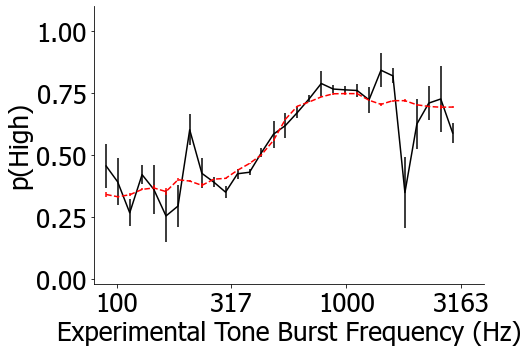

In [11]:
"""
Plotting cleaner fits from model by generating 1000 tone trials and corresponding behavior
"""

def plottingInfluenceFn(tones, behaviour):
    unique_tones = np.unique(tones)

    tone1_prob_behaviour = np.zeros((len(unique_tones),1))
    tone2_prob_behaviour = np.zeros((len(unique_tones),1))
    tone3_prob_behaviour = np.zeros((len(unique_tones),1))

    for i_tone in range(len(unique_tones)):
        tone1_prob_behaviour[i_tone] = np.mean(behaviour[tones[:,0]==unique_tones[i_tone]])
        tone2_prob_behaviour[i_tone] = np.mean(behaviour[tones[:,1]==unique_tones[i_tone]])
        tone3_prob_behaviour[i_tone] = np.mean(behaviour[tones[:,2]==unique_tones[i_tone]])
    behaviour = np.concatenate((tone1_prob_behaviour,tone2_prob_behaviour,tone3_prob_behaviour),axis=1)
    return unique_tones, behaviour    
    
unique_tones_played, subjectBehaviour = plottingInfluenceFn(trial_tones, trial_behaviour)   
fig, ax = plt.subplots(1,1,figsize=(7,5))
ax.errorbar(np.log10(unique_tones_played), np.mean(subjectBehaviour,axis=1),
             yerr=np.std(subjectBehaviour,axis=1)/np.sqrt(3),color='k')

moreTrainingTrials, _,_,_,_ = task(freq_seq = expt_tones, 
                                    n_trials = 6000, n_tones = 3, 
                                    p_back=0.3, p_low=0.5,
                                    lm=2.55,hm=2.85,s=0.1)

all_trial_tones, probability_sim_high = generate_behaviour(moreTrainingTrials, reps=1, n_tones=3, 
                                                          prob_back = 0.86, prob_low = 0.55, 
                                                          log_prior_params=[2.12,2.93,0.05], 
                                                          sigma_sensory=0.43)

unique_tones_played, subjectBehaviourBasedOnModel = plottingInfluenceFn(all_trial_tones, probability_sim_high) 

ax.errorbar(np.log10(unique_tones_played), np.mean(subjectBehaviourBasedOnModel,axis=1),
             yerr=np.std(subjectBehaviourBasedOnModel,axis=1)/np.sqrt(3), color='r',linestyle='--')

ax.set_xlim([1.9,3.6])
ax.set_ylim([-0.02,1.1])
ax.set_xticks(ticks=np.arange(2,3.6,0.5))
ax.set_xticklabels(np.ceil(10**np.arange(2,3.6,0.5)).astype(int))
ax.tick_params(axis='both',labelsize=26)
ax.set_xlabel('Experimental Tone Burst Frequency (Hz)',fontsize=26)
ax.set_ylabel('p(High)',fontsize=26)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig('figures/FromProlific/rawDataAnalysis/experimenter=efc1_cleaner_modelfit.eps',
           bbox_inches='tight',format='eps')

Norm of distractor weights compared to norm of all weights no context 0.6808548523060886


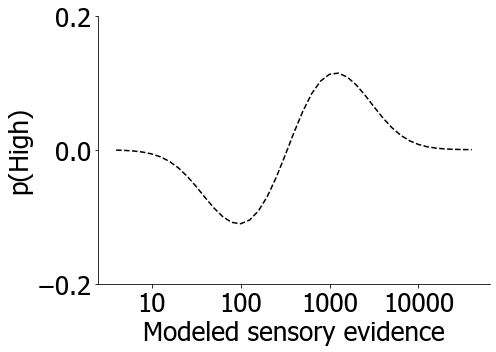

In [12]:
"""
What does the underlying posterior look like?
"""

def posteriorAgainstPercept(expt_Params):
    [_,_,mle_LikelihoodLatentTonegivenHigh,
    mle_LikelihoodLatentTonegivenLow,_,mle_posterior] = posterior_array(freq_input=log_freq_percept,
                                                                        n_tones=3,p_back=expt_Params[4],
                                                                        p_low=expt_Params[5],
                                                                        log_prior=expt_Params[:3]) 
    
    
    mle_LikelihoodPerceptgivenHigh = np.zeros((len(log_freq_percept),
                                               len(log_freq_percept),len(log_freq_percept)))
    mle_LikelihoodPerceptgivenLow = np.zeros((len(log_freq_percept),
                                              len(log_freq_percept),len(log_freq_percept)))

    for itrue1 in range(len(log_freq_percept)):
        for itrue2 in range(len(log_freq_percept)):
            for itrue3 in range(len(log_freq_percept)):
                mle_probPerceptgivenLatentTones = Tones3dgrid([log_freq_percept[itrue1],
                                                               log_freq_percept[itrue2],
                                                               log_freq_percept[itrue3]],
                                                               sigma=expt_Params[3])
                mle_LikelihoodPerceptgivenHigh \
                += mle_probPerceptgivenLatentTones * mle_LikelihoodLatentTonegivenHigh[itrue1,itrue2,itrue3]
                mle_LikelihoodPerceptgivenLow \
                += mle_probPerceptgivenLatentTones * mle_LikelihoodLatentTonegivenLow[itrue1,itrue2,itrue3]
    mle_probHighgivenPercept = mle_LikelihoodPerceptgivenHigh*(1-expt_Params[5])/\
    (mle_LikelihoodPerceptgivenHigh*(1-expt_Params[5]) + mle_LikelihoodPerceptgivenLow*expt_Params[5])
    return mle_probHighgivenPercept

minMLE_probHighgivenPercept = posteriorAgainstPercept([2.12,2.93,0.05,0.43,0.86,0.55])

tone1_prob_behaviour = np.zeros((len(log_freq_percept)))
tone2_prob_behaviour = np.zeros((len(log_freq_percept)))
tone3_prob_behaviour = np.zeros((len(log_freq_percept)))

for i_tone in range(len(log_freq_percept)):
    tone1_prob_behaviour[i_tone] = np.mean(minMLE_probHighgivenPercept[i_tone,:,:])
    tone2_prob_behaviour[i_tone] = np.mean(minMLE_probHighgivenPercept[:,i_tone,:])
    tone3_prob_behaviour[i_tone] = np.mean(minMLE_probHighgivenPercept[:,:,i_tone])

posteriorProbabilities = (tone1_prob_behaviour+tone2_prob_behaviour+tone3_prob_behaviour)/3
posteriorProbabilities = posteriorProbabilities - posteriorProbabilities[0]
fig, ax = plt.subplots(1,1,figsize=(7,5))
ax.errorbar(log_freq_percept, posteriorProbabilities,
            yerr=np.std([tone1_prob_behaviour,tone2_prob_behaviour,tone3_prob_behaviour],axis=0)/np.sqrt(3),
            color='black', ls='--')
ax.set_xlabel('Modeled sensory evidence',fontsize=26,)
ax.set_ylabel('p(High)',fontsize=26)
ax.set_xticks(ticks=np.arange(1,4.7,1))
ax.set_xticklabels(np.ceil(10**np.arange(1,4.7,1)).astype(int))
ax.set_yticks(ticks=[-0.2,0,0.2])
ax.tick_params(axis='both',labelsize=26)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()  
print("Norm of distractor weights compared to norm of all weights no context",
      (sum(np.abs(posteriorProbabilities[:17]))+
       sum(np.abs(posteriorProbabilities[-15:])))/sum(np.abs(posteriorProbabilities)))
pd.DataFrame(posteriorProbabilities).to_csv("figures/FromProlific/rawDataAnalysis/efc1_noContext_posteriorProbabilities.csv")
plt.savefig('figures/FromProlific/rawDataAnalysis/experimenter=efc1_posteriorUsingPercepts.eps',
           bbox_inches='tight',format='eps')


In [ ]:
"""
New optimization algorithm: uses scipy.optimize.fmin. 
Crude grid initially and then find minimum using the function.
"""
guess_low_mean = np.arange(2.1,2.71,0.15); guess_high_mean = np.arange(2.7,3.31,0.15); 
guess_sigma = np.arange(0.05,1,0.2); guess_sensory_sigma = np.array([0.14]);
guess_p_back = np.array([0]); guess_p_low = np.arange(0.4,0.61,0.05)

# Constraining guesses of means of low and high distributions based on observed behaviour in figure shown above. 

neg_ll_array = np.zeros((len(guess_low_mean), len(guess_high_mean),
                         len(guess_sigma), len(guess_sensory_sigma), 
                         len(guess_p_back), len(guess_p_low)))
for lm in tqdm(range(len(guess_low_mean))):
    for hm in tqdm(range(len(guess_high_mean)), leave=False, desc="High mean"):
        for s in range(len(guess_sigma)):
            for ss in range(len(guess_sensory_sigma)):
                for pb in range(len(guess_p_back)):
                    for pl in range(len(guess_p_low)):
                        params = [guess_low_mean[lm], guess_high_mean[hm], guess_sigma[s], \
                                  guess_sensory_sigma[ss], guess_p_back[pb], guess_p_low[pl]]
                        # print(lm, hm, pb)
                        neg_ll_array[lm,hm,s,ss,pb,pl],_ = MLE(params) 


In [ ]:
"""
Means and p_back corresponding to the least negative log likelihood value
"""
idxs = np.where(neg_ll_array == np.amin(neg_ll_array)) 
best_thetas = np.array([guess_low_mean[idxs[0]], guess_high_mean[idxs[1]], guess_sigma[idxs[2]], \
                        guess_sensory_sigma[idxs[3]], guess_p_back[idxs[4]], guess_p_low[idxs[5]]])
print(best_thetas, np.amin(neg_ll_array))


In [ ]:
# define mle function
def MLE_fmin(params):
    log_prior_low_mean, log_prior_high_mean, log_prior_sigma, sigma_sensory, prob_back, prob_low = \
    params[0], params[1], params[2], params[3], params[4], params[5] # inputs are guesses at our parameters  
    
    _,_,LikelihoodLatentTonegivenHigh,LikelihoodLatentTonegivenLow,_,_ = \
    posterior_array(log_freq_seq_array, n_tones=len(trial_tones[0]), p_back=prob_back, p_low=prob_low,\
                    log_prior=[log_prior_low_mean,log_prior_high_mean,log_prior_sigma])

    LikelihoodPerceptgivenHigh = np.zeros((len(log_freq_percept),len(log_freq_percept),len(log_freq_percept)))
    LikelihoodPerceptgivenLow = np.zeros((len(log_freq_percept),len(log_freq_percept),len(log_freq_percept)))
    
    for itrue1 in range(len(log_freq_seq_array)):
        for itrue2 in range(len(log_freq_seq_array)):            
            for itrue3 in range(len(log_freq_seq_array)):
                probPerceptgivenLatentTones = Tones3dgrid([log_freq_seq_array[itrue1],\
                                                           log_freq_seq_array[itrue2],\
                                                           log_freq_seq_array[itrue3]],sigma=sigma_sensory)                                                           
                LikelihoodPerceptgivenHigh \
                += probPerceptgivenLatentTones * LikelihoodLatentTonegivenHigh[itrue1,itrue2,itrue3]
                LikelihoodPerceptgivenLow \
                += probPerceptgivenLatentTones * LikelihoodLatentTonegivenLow[itrue1,itrue2,itrue3]
    probHighgivenPercept = LikelihoodPerceptgivenHigh*(1-prob_low)/\
    (LikelihoodPerceptgivenHigh*(1-prob_low) + LikelihoodPerceptgivenLow*(prob_low))
        
    neg_ll = 0; 
    probability_high = np.zeros((len(trial_tones),1))
    for i_trial in range(len(trial_tones)):
        input_array_mat = Tones3dgrid(np.array([np.log10(trial_tones[i_trial][0]),\
                                               np.log10(trial_tones[i_trial][1]),
                                               np.log10(trial_tones[i_trial][2])]),sigma=sigma_sensory)
        probability_high0 = np.sum(np.multiply(probHighgivenPercept>0.5,input_array_mat))
        probability_high[i_trial] = np.sum(np.multiply(probHighgivenPercept>0.5,input_array_mat))
            
        if trial_behaviour[i_trial]:
            if np.isnan(np.log(probability_high0 + 0.0000001)) \
            or np.isinf(np.log(probability_high0 + 0.0000001)) \
            or np.isnan(np.log(1-probability_high0 + 0.0000001)) \
            or np.isinf(np.log(1-probability_high0 + 0.0000001)):
                pdb.set_trace()
            neg_ll += -np.log(probability_high0 + 0.0000001) # if high dist is chosen by observer
        else:
            neg_ll += -np.log(1 - probability_high0 + 0.0000001) # if low dist is chosen by observer
    print(params, neg_ll)
    return(neg_ll)

"""
Optimization using neadler mead method and a simplex algorithm
"""
minimum_nll = scipy.optimize.fmin(MLE_fmin, [2.46,2.9,0.057,0.19,0.26,0.49], maxiter=10000, maxfun=10000, 
                                  xtol=0.01, ftol=0.01)

print(minimum_nll)
